In [12]:
# ================================================================
# Bachelor Thesis — Fairness in Toxic Comment Classification
# ---------------------------------------------------------------
# Notebook: cda_model_training_and_evaluation.ipynb
# Author: Philipp Stocker
# Created: 30.11.2025
# Purpose: TODO: fill purpose
# ================================================================

# --- Basic setup ---
import os
import sys
import warnings
warnings.filterwarnings("ignore")  # keep output clean for reports

# Automatically add project root to path so src/ modules are importable
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# --- Standard imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import joblib

from src.modeling import train_lr_tfidf
from src.modeling import predict_with_model
from src.modeling import extract_feature_and_label_arrays
from src.modeling import find_best_threshold

from src.bias_mitigation import apply_cda_augmentation

from src.data_preprocessing_and_preparation import build_tfidf_vectorizer

from src.metrics import compute_overall_metrics
from src.metrics import evaluate_subgroups

from src.visualization import (
    plot_performance_bar,
    plot_roc_curve,
    plot_pr_curve,
    plot_confusion_matrix,
    plot_auc_bars,
    plot_rate_gaps_bars,
    print_small_sample_warnings
)

# --- "Global variables" ---
DATA_RAW = os.path.join(project_root, "data", "raw")
DATA_PROCESSED = os.path.join(project_root, "data", "processed")

IDENTITY_COLUMNS = ["male", "female", "heterosexual", "homosexual_gay_or_lesbian", "bisexual", "transgender", "other_gender", "other_sexual_orientation"]

print("✅ Environment ready")


✅ Environment ready


DATA PREPARATION

Load train dataset and apply cda augmentation:

In [13]:
# Load processed dataframes from parquet files
train_df = pd.read_parquet(os.path.join(DATA_PROCESSED, "train_processed.parquet"))
val_df = pd.read_parquet(os.path.join(DATA_PROCESSED, "validation_processed.parquet"))
test_df = pd.read_parquet(os.path.join(DATA_PROCESSED, "test_processed.parquet"))

# Ensure that processed comment texts are strings and handle any missing values
train_df["comment_text_processed"] = train_df["comment_text_processed"].astype(str).fillna("")
val_df["comment_text_processed"]   = val_df["comment_text_processed"].astype(str).fillna("")
test_df["comment_text_processed"]  = test_df["comment_text_processed"].astype(str).fillna("")

# Apply CDA augmentation
train_df = apply_cda_augmentation(train_df, text_col="comment_text_processed")

# Save processed dataframe to parquet
train_df.to_parquet(os.path.join(DATA_PROCESSED, "train_processed_cda.parquet"), index=False)

CDA augmentation summary (number of new samples per group):
  heterosexual: 15387
  homosexual_gay_or_lesbian: 5391
  bisexual: 243
  transgender: 4104


Apply data transformation:

In [14]:
# build TF-IDF vectorizer based on training data (with standard parameters)
vectorizer = build_tfidf_vectorizer()

# extract necessary columns for model training and evaluation
x_train = train_df["comment_text_processed"]
y_train = train_df["labelled_as_toxic"]

x_val = val_df["comment_text_processed"]
y_val = val_df["labelled_as_toxic"]

x_test = test_df["comment_text_processed"]
y_test = test_df["labelled_as_toxic"]

In [15]:
# apply transformation
x_train_vec = vectorizer.fit_transform(x_train) # use fit (Learns the vocabulary and IDF weights) only on training data to avoid data leakage
x_val_vec   = vectorizer.transform(x_val) 
x_test_vec  = vectorizer.transform(x_test)

In [16]:
# print shapes of the resulting vectors
print("Shapes (train/val/test):", x_train_vec.shape, x_val_vec.shape, x_test_vec.shape)

Shapes (train/val/test): (1288536, 1104334) (270732, 1104334) (270731, 1104334)


Save vectorizer and bundle of vectorized data + its label (for potential further use):

In [17]:
# Save the vectorizer for later use
joblib.dump(vectorizer, project_root + "/models/tfidf_vectorizer_cda.joblib")

# Save bundles of vectorized data + its label
joblib.dump(
    {"x": x_train_vec, "y": y_train},
    project_root + "/data/processed/train_tfidf_bundle_cda.joblib"
)

joblib.dump(
    {"x": x_val_vec, "y": y_val},
    project_root + "/data/processed/val_tfidf_bundle_cda.joblib"
)

joblib.dump(
    {"x": x_test_vec, "y": y_test},
    project_root + "/data/processed/test_tfidf_bundle_cda.joblib"
)

['c:\\Users\\phili\\OneDrive\\Dokumente\\Uni\\Kurse\\7. Semester\\Bachelorarbeit\\BA_Arbeitsmappe\\BachelorThesis_BiasInToxicCommentClassification/data/processed/test_tfidf_bundle_cda.joblib']

Load feature and label arrays

In [18]:
x_train, y_train = extract_feature_and_label_arrays(joblib.load(os.path.join(DATA_PROCESSED, "train_tfidf_bundle_cda.joblib")))
x_val, y_val = extract_feature_and_label_arrays(joblib.load(os.path.join(DATA_PROCESSED, "val_tfidf_bundle_cda.joblib")))
x_test, y_test = extract_feature_and_label_arrays(joblib.load(os.path.join(DATA_PROCESSED, "test_tfidf_bundle_cda.joblib")))

CDA MODEL TRAINING

Train model with CDA as bias mitigation strategy including hyperparameter tuning and calibration

In [9]:
# Train cda model: Logistic Regression with TF-IDF features (per default with hyperparameter tuning and calibration)
cda_models = train_lr_tfidf(
    x_train=x_train,
    y_train=y_train
)

# Save trained cda models
joblib.dump(cda_models, project_root + "/models/tfidf_cda_models.joblib")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=  34.9s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=  36.2s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=  35.7s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=  35.1s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=  32.2s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=  27.6s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=  26.3s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=  26.8s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=  24.7s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=  24.8s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=  47.4s
[CV] END C

['c:\\Users\\phili\\OneDrive\\Dokumente\\Uni\\Kurse\\7. Semester\\Bachelorarbeit\\BA_Arbeitsmappe\\BachelorThesis_BiasInToxicCommentClassification/models/tfidf_cda_models.joblib']

CDA MODEL EVALUATION

Load cda models for further evaluation

In [19]:
cda_models = joblib.load(project_root + "/models/tfidf_cda_models.joblib")

Calculate best threshold based on f1 score

In [20]:
y_val_proba = cda_models["model"].predict_proba(x_val)[:, 1]

threshold = find_best_threshold(y_val, y_val_proba)

Best threshold: 0.25 with F1-score: 0.6466


Conduct prediction on test dataset and print result

In [21]:
y_test_proba, y_test_pred = predict_with_model(cda_models["model"], x_test, threshold=threshold)

# Calculate and print number of toxic and non-toxic comments in test set
count_toxic = np.sum(y_test_pred)
count_nontoxic = len(y_test_pred) - count_toxic
print(f"Number of toxic comments: {count_toxic}")
print(f"Number of non-toxic comments: {count_nontoxic}")    

Number of toxic comments: 22650
Number of non-toxic comments: 248081


Optional: conduct prediction on test dataset with uncalibrated model for comparision

In [ ]:
if cda_models["uncalibrated_model"] is not None:
    y_test_proba_uncalibrated, y_test_pred_uncalibrated = predict_with_model(cda_models["uncalibrated_model"], x_test, threshold=threshold)
    count_toxic_uncalibrated = np.sum(y_test_pred_uncalibrated)
    count_nontoxic_uncalibrated = len(y_test_pred_uncalibrated) - count_toxic_uncalibrated
    print(f"Number of toxic comments (uncalibrated): {count_toxic_uncalibrated}")
    print(f"Number of non-toxic comments (uncalibrated): {count_nontoxic_uncalibrated}")

Number of toxic comments (uncalibrated): 70445
Number of non-toxic comments (uncalibrated): 200286


CDA MODEL PERFORMANCE METRICS

Calculate performance metrics

In [22]:
cda_model_overall_metrics = compute_overall_metrics(y_test, y_test_pred, y_test_proba)

print("Overall metrics for cda model:")
print(cda_model_overall_metrics)

Overall metrics for cda model:
{'accuracy': 0.941015251301107, 'precision': 0.625430463576159, 'recall': 0.6542884855202993, 'f1_score': 0.6395340962957947, 'roc_auc': 0.9481881812437558, 'pr_auc': 0.6975529621952425}


Visualize performance metrics

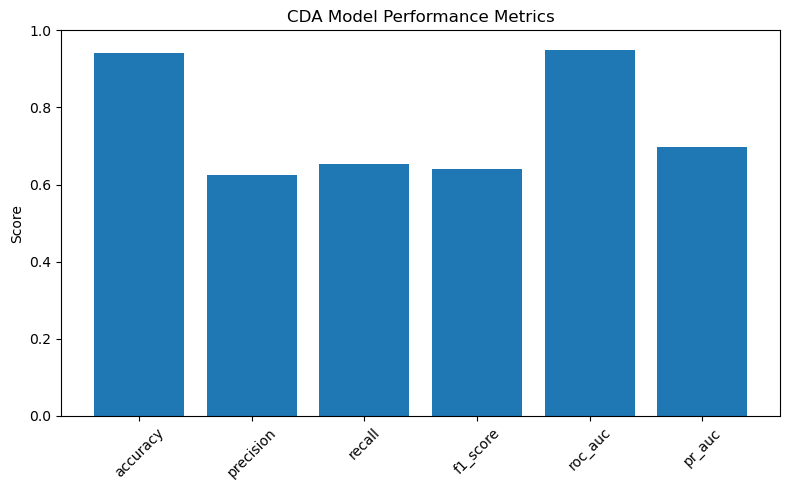

In [23]:
# Plot performance bars
plot_performance_bar(cda_model_overall_metrics, title="CDA Model Performance Metrics")

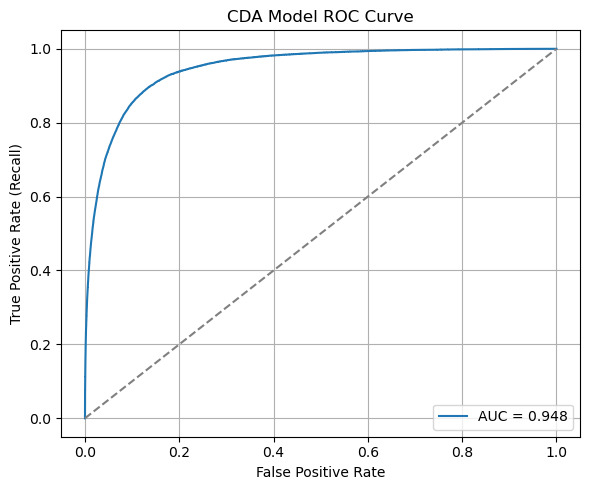

In [24]:
# Plot ROC curve
plot_roc_curve(y_test, y_test_proba, title="CDA Model ROC Curve")

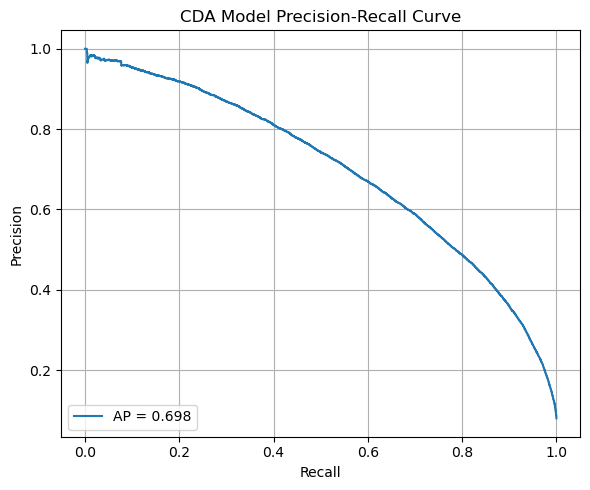

In [25]:
# Plot PR curve
plot_pr_curve(y_test, y_test_proba, title="CDA Model Precision-Recall Curve")

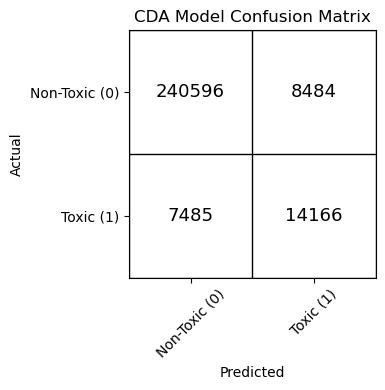

In [26]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred, title="CDA Model Confusion Matrix")

BASE MODEL FAIRNESS METRICS

Calculate fairness Metrics (per subgroup)

In [28]:
# Prepare test dataframe with predictions for subgroup evaluation
test_df = pd.read_parquet(os.path.join(DATA_PROCESSED, "test_processed.parquet")).copy()
test_df["predicted_proba"] = y_test_proba
test_df["predicted_label"] = y_test_pred

test_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,labelled_as_toxic,has_identity,comment_text_processed,predicted_proba,predicted_label
0,5555389,0.1,I listened to Scheer re Omar Khadr; he sounded...,0.0,0.0,0.1,0.1,0.0,NaN,NaN,...,3,2,0.0,0,10,0,0,i listened to scheer re omar khadr he sounded ...,0.045335,0
1,376072,0.0,For more on Pre check out; prespeople.com,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0,0,0.0,0,4,0,0,for more on pre check out prespeople com,0.003048,0
2,539767,0.4,They also have to go to places where people sh...,0.1,0.0,0.0,0.0,0.4,NaN,NaN,...,0,0,0.0,0,10,0,0,they also have to go to places where people sh...,0.401712,1
3,5556650,0.0,This is why many experts and policy makers are...,0.0,0.0,0.2,0.0,0.0,NaN,NaN,...,0,0,0.0,0,5,0,0,this is why many experts and policy makers are...,0.008513,0
4,333126,0.0,"Yeah, I know...many regular miles as well.",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0,0,0.0,0,4,0,0,yeah i know many regular miles as well,0.010247,0


In [29]:
# Conduct subgroup evaluation
subgroup_metrics_df = evaluate_subgroups(
    df=test_df,
    subgroup_cols=IDENTITY_COLUMNS,
    threshold=threshold
)

In [30]:
print(subgroup_metrics_df)

                    subgroup  n_subgroup    n_bg  n_sg_pos  n_sg_neg  \
0               heterosexual         189  270542        37       152   
1                   bisexual          38  270693         6        32   
2  homosexual_gay_or_lesbian        1604  269127       454      1150   
3                transgender         353  270378        88       265   
4                       male        6640  264091       985      5655   
5                     female        8107  262624      1093      7014   
6               other_gender           1  270730         0         1   
7   other_sexual_orientation           3  270728         3         0   

   subgroup_auc  bpsn_auc  bnsp_auc    sg_fpr    sg_fnr    bg_fpr    bg_fnr  \
0      0.718172  0.728353  0.961094  0.302632  0.324324  0.033897  0.345748   
1      0.770833  0.787159  0.962104  0.312500  0.500000  0.034026  0.345669   
2      0.773308  0.780120  0.957643  0.222609  0.372247  0.033187  0.345143   
3      0.813937  0.812862  0.956847

Visualize fairness metrics (per subgroup)

In [31]:
# Print warnings indicating subgroups with small sample sizes
# This helps to identify potential issues with metric stability due to limited data
print_small_sample_warnings(subgroup_metrics_df)

[WARN] bisexual: small sample -> n_subgroup=38
[WARN] other_gender: small sample -> n_subgroup=1, n_sg_pos=0, n_sg_neg=1
[WARN] other_sexual_orientation: small sample -> n_subgroup=3, n_sg_pos=3, n_sg_neg=0


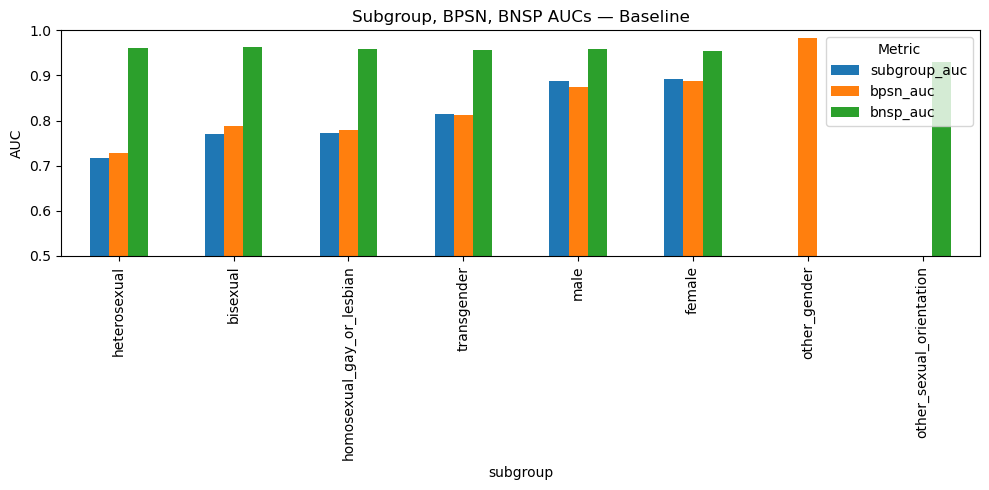

In [32]:
# Visualize auc bars
plot_auc_bars(subgroup_metrics_df)

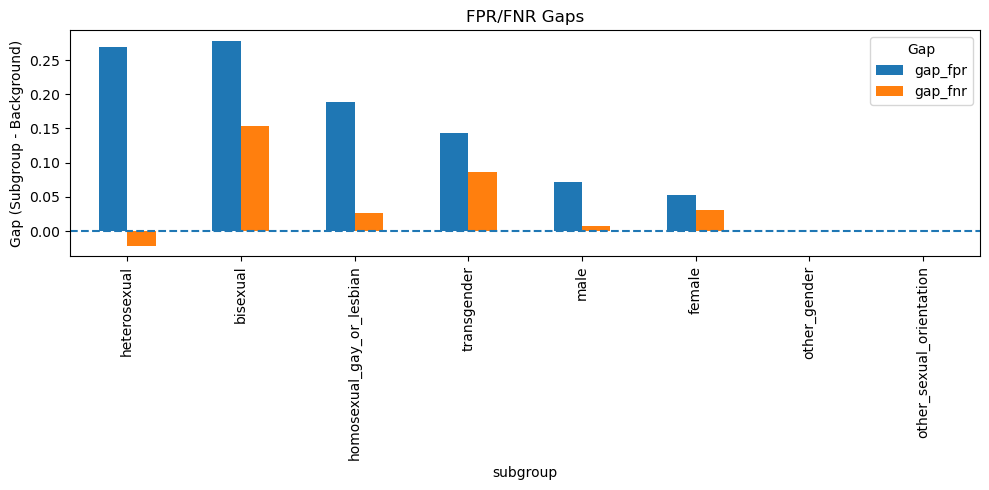

In [33]:
# Visualize fpr/fnr gaps bars
plot_rate_gaps_bars(subgroup_metrics_df)